In [37]:
import numpy as np
import pandas as pd
import pickle

import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.model_selection import KFold

pd.set_option('display.max_columns', None)

In [38]:
pickle_in = open("processed_film_data","rb")
film_df = pickle.load(pickle_in)

In [39]:
film_df.head()

,actors,budget,countries,directors,genres,gross_usa,languages,mpaa,rating,runtime,votes,writers
0,"[Tom Selleck, Laura San Giacomo, Alan Rickman]",20000000,+_+Australia+_+USA,Simon Wincer,"[Action, Adventure, Drama, Romance, Western]",21413105,"[English, Aboriginal]",PG-13,6.8,119.0,16501,John Hill
1,"[Kevin Costner, Mary McDonnell, Graham Greene]",22000000,+_+USA+_+UK,Kevin Costner,"[Adventure, Drama, Western]",184208848,"[English, Sioux, Pawnee]",PG-13,8.0,181.0,204981,Michael Blake
2,"[Tony Todd, Patricia Tallman, Tom Towles]",4200000,+_+USA,Tom Savini,[Horror],5835247,[English],R,6.9,92.0,33738,John A. Russo
3,"[Jonathan Brandis, Kenny Morrison, Clarissa Burt]",36000000,+_+USA+_+Germany,George Miller,"[Adventure, Drama, Family, Fantasy]",17373527,[English],PG,5.1,90.0,20152,Karin Howard
4,"[David Andrews, Kelly Wolf, Stephen Macht]",10500000,+_+USA+_+Japan,Ralph S. Singleton,[Horror],11582891,[English],R,4.8,89.0,7824,Stephen King


In [40]:
#Delete the rows I won't need.
del film_df['actors']
del film_df['countries']
del film_df['languages']
del film_df['writers']
del film_df['directors']

In [41]:
#Expand genres into dummy columns
genres = film_df['genres'].str.join('|').str.get_dummies()
genres.reset_index(drop=True, inplace=True)
film_df = pd.concat([film_df, genres], axis=1)
del film_df['genres']

In [42]:
#Expand MPAA into dummy columns
mpaa = film_df['mpaa'].str.get_dummies()
mpaa.reset_index(inplace=True, drop=True)
film_df = pd.concat([film_df, mpaa], axis=1)
del film_df['mpaa']

In [43]:
#Based on Modeling 1, I am going to perform a log transform on my data
film_df['budget'] = film_df['budget'].apply(lambda x: np.log(x))
film_df['gross_usa'] = film_df['gross_usa'].apply(lambda x: np.log(x))
film_df['runtime'] = film_df['runtime'].apply(lambda x: np.log(x))
film_df['votes'] = film_df['votes'].apply(lambda x: np.log(x))

In [44]:
#Look at the correlation matrix
film_df.corr()

,budget,gross_usa,rating,runtime,votes,Action,Adventure,Animation,Biography,Comedy,Crime,Drama,Family,Fantasy,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western,G,NC-17,NOT RATED,PG,PG-13,R,TV-14,TV-G,TV-MA,TV-PG,UNRATED
budget,1.000000,0.698278,0.101495,0.393750,0.645948,0.310414,0.343959,0.168265,0.017198,-0.027662,0.036023,-0.204201,0.201185,0.205618,0.067595,-0.130047,-0.012614,0.051738,0.040377,-0.044256,0.183591,0.025935,0.091082,0.063698,0.037848,0.066492,-0.019601,-0.330770,0.134067,0.249108,-0.216130,-0.071172,-0.019428,-0.066213,-0.020933,-0.190767
gross_usa,0.698278,1.000000,0.224856,0.298929,0.735892,0.205705,0.277565,0.152757,0.016844,0.031347,-0.015219,-0.215913,0.199957,0.169179,0.035997,-0.059762,-0.004552,0.039682,0.049948,-0.012132,0.131727,0.036388,0.041757,-0.000004,0.013659,0.071651,-0.016229,-0.318580,0.143035,0.229856,-0.219699,-0.025059,-0.029571,-0.066115,-0.018159,-0.124807
rating,0.101495,0.224856,1.000000,0.429287,0.435957,-0.079209,0.017774,0.075184,0.177882,-0.163902,0.058829,0.315516,-0.065250,-0.040898,0.123717,-0.213577,-0.004160,0.025188,0.032408,-0.002235,-0.040218,0.010631,-0.039481,0.102977,0.019593,0.008322,-0.004079,-0.030378,-0.066522,-0.054977,0.107481,-0.002406,0.001965,-0.015017,0.010709,-0.022533
runtime,0.393750,0.298929,0.429287,1.000000,0.366548,0.103995,0.057555,-0.231191,0.199320,-0.318802,0.041645,0.275393,-0.199361,-0.052236,0.230385,-0.178826,0.004869,-0.041462,0.044114,0.032141,0.042204,0.058916,0.062522,0.170315,0.077918,-0.152644,0.009480,-0.108916,-0.118166,0.121441,0.049158,0.009236,0.012453,-0.029260,-0.016978,-0.062161
votes,0.645948,0.735892,0.435957,0.366548,1.000000,0.227455,0.235351,0.074452,0.029646,-0.084941,0.062956,-0.153465,0.033274,0.138572,0.038231,0.002876,-0.049372,0.001754,0.101459,-0.046564,0.189897,-0.030348,0.145050,0.032494,-0.000063,-0.012283,-0.000668,-0.262662,-0.030457,0.160215,-0.030295,-0.055596,-0.043637,-0.057372,-0.030755,-0.109400
Action,0.310414,0.205705,-0.079209,0.103995,0.227455,1.000000,0.312455,-0.017114,-0.100066,-0.189759,0.172289,-0.267974,-0.043547,0.051108,-0.013346,-0.050004,-0.084867,-0.068022,-0.035130,-0.191020,0.326168,-0.047460,0.305616,0.038212,0.047610,-0.069015,-0.018301,-0.053011,-0.051696,0.138704,-0.056591,-0.008181,-0.008181,-0.016367,-0.008181,-0.016990
Adventure,0.343959,0.277565,0.017774,0.057555,0.235351,0.312455,1.000000,0.353749,-0.071062,-0.004490,-0.143444,-0.267893,0.389508,0.317253,-0.009778,-0.109929,-0.056945,0.056897,-0.065956,-0.117429,0.253673,-0.058468,-0.062532,-0.005761,0.069142,0.185905,-0.015527,-0.058985,0.278014,0.088350,-0.300952,-0.006941,-0.006941,-0.013886,-0.006941,-0.033369
Animation,0.168265,0.152757,0.075184,-0.231191,0.074452,-0.017114,0.353749,1.000000,-0.047547,0.176021,-0.092014,-0.177676,0.556707,0.278810,-0.035510,-0.070514,0.009411,0.249640,-0.047186,-0.064269,0.053669,-0.007923,-0.135536,-0.016170,0.007519,0.432934,-0.007676,-0.033255,0.330581,-0.141474,-0.202180,-0.003431,-0.003431,-0.006865,-0.003431,-0.002103
Biography,0.017198,0.016844,0.177882,0.199320,0.029646,-0.100066,-0.071062,-0.047547,1.000000,-0.156613,-0.020364,0.215859,-0.062368,-0.088452,0.314224,-0.083430,0.063764,-0.001807,-0.076888,-0.028834,-0.087162,0.132496,-0.102871,0.103698,0.019591,-0.029452,-0.008259,-0.022191,-0.003765,0.003249,0.014252,-0.003692,-0.003692,0.024876,-0.003692,-0.004267
Comedy,-0.027662,0.031347,-0.163902,-0.318802,-0.084941,-0.189759,-0.004490,0.176021,-0.156613,1.000000,-0.115300,-0.271533,0.238100,0.054674,-0.141721,-0.189590,0.044778,0.053418,-0.220066,0.184958,-0.132718,0.006993,-0.419155,-0.121594,-0.048756,0.085256,-0.000429,0.005212,0.200090,-0.006160,-0.154967,-0.012395,-0.012395,-0.009539,-0.012395,0.010557


In [45]:
#Scale data
scaler = MinMaxScaler()

data = film_df.drop('rating', axis=1)
target = film_df['rating']

data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

In [46]:
#Check correlation matrix now
film_df.corr()

,budget,gross_usa,rating,runtime,votes,Action,Adventure,Animation,Biography,Comedy,Crime,Drama,Family,Fantasy,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western,G,NC-17,NOT RATED,PG,PG-13,R,TV-14,TV-G,TV-MA,TV-PG,UNRATED
budget,1.000000,0.698278,0.101495,0.393750,0.645948,0.310414,0.343959,0.168265,0.017198,-0.027662,0.036023,-0.204201,0.201185,0.205618,0.067595,-0.130047,-0.012614,0.051738,0.040377,-0.044256,0.183591,0.025935,0.091082,0.063698,0.037848,0.066492,-0.019601,-0.330770,0.134067,0.249108,-0.216130,-0.071172,-0.019428,-0.066213,-0.020933,-0.190767
gross_usa,0.698278,1.000000,0.224856,0.298929,0.735892,0.205705,0.277565,0.152757,0.016844,0.031347,-0.015219,-0.215913,0.199957,0.169179,0.035997,-0.059762,-0.004552,0.039682,0.049948,-0.012132,0.131727,0.036388,0.041757,-0.000004,0.013659,0.071651,-0.016229,-0.318580,0.143035,0.229856,-0.219699,-0.025059,-0.029571,-0.066115,-0.018159,-0.124807
rating,0.101495,0.224856,1.000000,0.429287,0.435957,-0.079209,0.017774,0.075184,0.177882,-0.163902,0.058829,0.315516,-0.065250,-0.040898,0.123717,-0.213577,-0.004160,0.025188,0.032408,-0.002235,-0.040218,0.010631,-0.039481,0.102977,0.019593,0.008322,-0.004079,-0.030378,-0.066522,-0.054977,0.107481,-0.002406,0.001965,-0.015017,0.010709,-0.022533
runtime,0.393750,0.298929,0.429287,1.000000,0.366548,0.103995,0.057555,-0.231191,0.199320,-0.318802,0.041645,0.275393,-0.199361,-0.052236,0.230385,-0.178826,0.004869,-0.041462,0.044114,0.032141,0.042204,0.058916,0.062522,0.170315,0.077918,-0.152644,0.009480,-0.108916,-0.118166,0.121441,0.049158,0.009236,0.012453,-0.029260,-0.016978,-0.062161
votes,0.645948,0.735892,0.435957,0.366548,1.000000,0.227455,0.235351,0.074452,0.029646,-0.084941,0.062956,-0.153465,0.033274,0.138572,0.038231,0.002876,-0.049372,0.001754,0.101459,-0.046564,0.189897,-0.030348,0.145050,0.032494,-0.000063,-0.012283,-0.000668,-0.262662,-0.030457,0.160215,-0.030295,-0.055596,-0.043637,-0.057372,-0.030755,-0.109400
Action,0.310414,0.205705,-0.079209,0.103995,0.227455,1.000000,0.312455,-0.017114,-0.100066,-0.189759,0.172289,-0.267974,-0.043547,0.051108,-0.013346,-0.050004,-0.084867,-0.068022,-0.035130,-0.191020,0.326168,-0.047460,0.305616,0.038212,0.047610,-0.069015,-0.018301,-0.053011,-0.051696,0.138704,-0.056591,-0.008181,-0.008181,-0.016367,-0.008181,-0.016990
Adventure,0.343959,0.277565,0.017774,0.057555,0.235351,0.312455,1.000000,0.353749,-0.071062,-0.004490,-0.143444,-0.267893,0.389508,0.317253,-0.009778,-0.109929,-0.056945,0.056897,-0.065956,-0.117429,0.253673,-0.058468,-0.062532,-0.005761,0.069142,0.185905,-0.015527,-0.058985,0.278014,0.088350,-0.300952,-0.006941,-0.006941,-0.013886,-0.006941,-0.033369
Animation,0.168265,0.152757,0.075184,-0.231191,0.074452,-0.017114,0.353749,1.000000,-0.047547,0.176021,-0.092014,-0.177676,0.556707,0.278810,-0.035510,-0.070514,0.009411,0.249640,-0.047186,-0.064269,0.053669,-0.007923,-0.135536,-0.016170,0.007519,0.432934,-0.007676,-0.033255,0.330581,-0.141474,-0.202180,-0.003431,-0.003431,-0.006865,-0.003431,-0.002103
Biography,0.017198,0.016844,0.177882,0.199320,0.029646,-0.100066,-0.071062,-0.047547,1.000000,-0.156613,-0.020364,0.215859,-0.062368,-0.088452,0.314224,-0.083430,0.063764,-0.001807,-0.076888,-0.028834,-0.087162,0.132496,-0.102871,0.103698,0.019591,-0.029452,-0.008259,-0.022191,-0.003765,0.003249,0.014252,-0.003692,-0.003692,0.024876,-0.003692,-0.004267
Comedy,-0.027662,0.031347,-0.163902,-0.318802,-0.084941,-0.189759,-0.004490,0.176021,-0.156613,1.000000,-0.115300,-0.271533,0.238100,0.054674,-0.141721,-0.189590,0.044778,0.053418,-0.220066,0.184958,-0.132718,0.006993,-0.419155,-0.121594,-0.048756,0.085256,-0.000429,0.005212,0.200090,-0.006160,-0.154967,-0.012395,-0.012395,-0.009539,-0.012395,0.010557


# Diagnostics

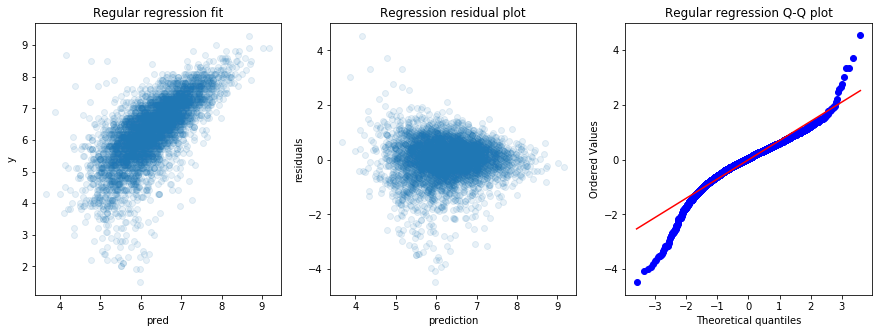

In [47]:
#Diagnostic plots
plt.figure(figsize=(15,5))

X, y = data, target

rgr = LinearRegression()
rgr.fit(X, y)
pred = rgr.predict(X)

plt.subplot(1, 3, 1)
plt.scatter(pred, y, alpha = 0.1)
plt.title("Regular regression fit")
plt.xlabel("pred")
plt.ylabel("y")

plt.subplot(1, 3, 2)
res = (y - pred)
plt.scatter(pred, res, alpha = 0.1)
plt.title("Regression residual plot")
plt.xlabel("prediction")
plt.ylabel("residuals")

plt.subplot(1, 3, 3)
pred = rgr.predict(X)
stats.probplot(res, dist="norm", plot=plt)
plt.title("Regular regression Q-Q plot");

In [48]:
#Check the stats of the model, particularly the p-values
model = sm.OLS(y,X)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.508
Model:                            OLS   Adj. R-squared:                  0.504
Method:                 Least Squares   F-statistic:                     134.2
Date:                Mon, 05 Feb 2018   Prob (F-statistic):               0.00
Time:                        11:40:25   Log-Likelihood:                -4865.6
No. Observations:                4455   AIC:                             9801.
Df Residuals:                    4420   BIC:                         1.003e+04
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
budget        -2.8121      0.138    -20.401      0.000      -3.082      -2.542
gross_usa     -0.1237      0.109     -1.138      0.255      -0.337       0.089
runtime        3.6485      0.171     21.324      0.000       3.313       3.984
votes          4.5585      0.126     36.271      0.000       4.312       4.805
Action        -0.1662      0.033     -5.035      0.000      -0.231      -0.101
Adventure     -0.0240      0.037     -0.651      0.515      -0.096       0.048
Animation      0.9770      0.066     14.745      0.000       0.847       1.107
Biography      0.1497      0.052      2.886      0.004       0.048       0.251
Comedy        -0.1196      0.029     -4.091      0.000      -0.177      -0.062
Crime          0.0251      0.032      0.782      0.434      -0.038       0.088
Drama          0.3810      0.028     13.440      0.000       0.325       0.437
Family        -0.1752      0.061     -2.877      0.004      -0.295      -0.056
Fantasy       -0.0889      0.038     -2.354      0.019      -0.163      -0.015
History       -0.0514      0.070     -0.734      0.463      -0.189       0.086
Horror        -0.5354      0.042    -12.756      0.000      -0.618      -0.453
Music         -0.0833      0.059     -1.419      0.156      -0.199       0.032
Musical        0.0212      0.081      0.261      0.794      -0.138       0.181
Mystery        0.0482      0.037      1.291      0.197      -0.025       0.122
Romance       -0.1291      0.028     -4.553      0.000      -0.185      -0.074
Sci-Fi        -0.0875      0.038     -2.294      0.022      -0.162      -0.013
Sport         -0.0548      0.060     -0.921      0.357      -0.171       0.062
Thriller      -0.1744      0.031     -5.589      0.000      -0.236      -0.113
War            0.0538      0.069      0.779      0.436      -0.082       0.189
Western        0.0185      0.093      0.199      0.842      -0.164       0.201
G              3.9159      0.130     30.030      0.000       3.660       4.172
NC-17          3.2139      0.336      9.556      0.000       2.554       3.873
NOT RATED      4.0330      0.105     38.370      0.000       3.827       4.239
PG             3.7858      0.103     36.860      0.000       3.584       3.987
PG-13          3.6460      0.096     37.798      0.000       3.457       3.835
R              3.7652      0.093     40.590      0.000       3.583       3.947
TV-14          3.5926      0.729      4.927      0.000       2.163       5.022
TV-G           4.5916      0.730      6.292      0.000       3.161       6.022
TV-MA          3.6332      0.368      9.861      0.000       2.911       4.355
TV-PG          5.2285      0.728      7.184      0.000       3.802       6.655
UNRATED        3.5503      0.167     21.215      0.000       3.222       3.878
==============================================================================
Om

# Models

In [49]:
#Define this function to help me calculate RMSE later on.
def RMSE(actuals, preds): 
    return np.sqrt(np.mean((actuals - preds)**2))

In [50]:
#Split the data into training, test, and valdiation sets
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=42) 
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=3)

kf = KFold(n_splits=5, shuffle=True, random_state = 71)

## Model 1 - Basic Linear Regression

In [51]:
#Initialize the model
lr_model_1 = LinearRegression()
lr_model_1.fit(X_train, y_train);

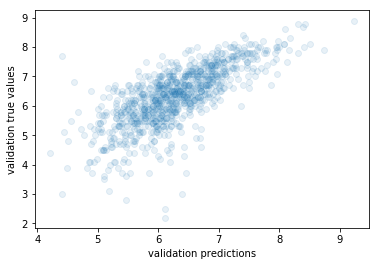

In [52]:
#Perform basic validation and look at the results.
plt.scatter(lr_model_1.predict(X_val), y_val, alpha=.1)
plt.plot(np.linspace(0,12,0.1),np.linspace(0,12,0.1))
plt.xlabel("validation predictions")
plt.ylabel("validation true values");

In [53]:
#Look at the model's RMSE and r^2
print("Basic Linear Regression RMSE: %.3f" %(RMSE(y_val, lr_model_1.predict(X_val))))
print("Basic Linear Regression r^2: %.3f" %(lr_model_1.score(X_val, y_val)))

Basic Linear Regression RMSE: 0.690
Basic Linear Regression r^2: 0.528


In [54]:
#Perform cross-validation
X_cv, y_cv = np.array(X), np.array(y)

cv_lm_r2s = []
cv_lm_rmse = []

for train_ind, val_ind in kf.split(X_cv, y_cv):
    
    X_cv_train, y_cv_train = X_cv[train_ind], y_cv[train_ind]
    X_val, y_val = X_cv[val_ind], y_cv[val_ind] 
    
    lr_model_1.fit(X_cv_train, y_cv_train)
    
    cv_lm_r2s.append(lr_model_1.score(X_val, y_val))
    cv_lm_rmse.append(RMSE(y_val, lr_model_1.predict(X_val)))

#Check RMSE and r^2 for cross-validation.   
print('Basic Linear Regression mean cv r^2: %.3f +- %.3f' %(np.mean(cv_lm_r2s),np.std(cv_lm_r2s)))
print('Basic Linear Regression mean cv RMSE: %.3f +- %.3f' %(np.mean(cv_lm_rmse),np.std(cv_lm_rmse)))

Basic Linear Regression mean cv r^2: 0.501 +- 0.028
Basic Linear Regression mean cv RMSE: 0.713 +- 0.017


In [55]:
#Check r^2 on the test set.
lr_model_1.score(X_test, y_test)

0.47797953979901109

## Model 2 - LASSO regularization

In [56]:
#Define alphavec for LASSO and Ridge CV
alphavec = 10**np.linspace(-5,5,10)

In [57]:
#Scale the training set
std = StandardScaler()
std.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [58]:
#Transform the training data for LASSO regularization
X_lasso_train = std.transform(X_train)
X_lasso_val = std.transform(X_val);

In [59]:
#Initialize the model and perform cross-validation using in-built methods.
lr_model_2 = LassoCV(alphas = alphavec, cv=5)
lr_model_2.fit(X_lasso_train,y_train)

LassoCV(alphas=array([  1.00000e-05,   1.29155e-04,   1.66810e-03,   2.15443e-02,
         2.78256e-01,   3.59381e+00,   4.64159e+01,   5.99484e+02,
         7.74264e+03,   1.00000e+05]),
    copy_X=True, cv=5, eps=0.001, fit_intercept=True, max_iter=1000,
    n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [60]:
#Look at the coefficients.
list(zip(X_train.columns, lr_model_2.coef_))

[('budget', -0.37873905683708359),
 ('gross_usa', -0.0352259577168927),
 ('runtime', 0.32520951068564147),
 ('votes', 0.64419071257442428),
 ('Action', -0.060965579936380791),
 ('Adventure', 0.00031804773260721368),
 ('Animation', 0.2204587053980222),
 ('Biography', 0.028716307893518121),
 ('Comedy', -0.049089901561303814),
 ('Crime', 0.014378982480479502),
 ('Drama', 0.18738944733469234),
 ('Family', -0.032868318183580589),
 ('Fantasy', -0.039938683159295399),
 ('History', 0.0019412057600758598),
 ('Horror', -0.15378692884668985),
 ('Music', -0.011923088324571705),
 ('Musical', -0.0081835335422064809),
 ('Mystery', 0.024086815646341523),
 ('Romance', -0.050790389191715204),
 ('Sci-Fi', -0.031135669710376533),
 ('Sport', -0.011092099337099353),
 ('Thriller', -0.084354170956222704),
 ('War', 0.0),
 ('Western', 0.015316062498831596),
 ('G', 0.01666143760988259),
 ('NC-17', -0.032789975697348581),
 ('NOT RATED', 0.027044442132959194),
 ('PG', -0.0),
 ('PG-13', -0.050717324716828535),
 ('R

In [61]:
#Look at a single validation sert.
val_set_pred_2 = lr_model_2.predict(X_lasso_val)

In [62]:
#Check RMSE and r^2 for LASSO regularization for one validation set.
print('LASSO mean cv r^2: %.3f' %lr_model_2.score(X_lasso_val, y_val))
print('LASSO mean cv RMSE: %.3f' %np.sqrt(np.mean((val_set_pred_2 - y_val)**2)))

LASSO mean cv r^2: 0.546
LASSO mean cv RMSE: 0.685


In [63]:
#Check the model's r^2 on the test data.
lr_model_2.score(std.transform(X_test), y_test)

0.48074908739857047

## Model 3 - Ridge Regularization

In [64]:
#Scale the data
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [65]:
#Initialize the model and perform built-in cross-validation.
lr_model_3 = RidgeCV(alphas = alphavec, cv=5)
lr_model_3.fit(X_train_scaled,y_train)

RidgeCV(alphas=array([  1.00000e-05,   1.29155e-04,   1.66810e-03,   2.15443e-02,
         2.78256e-01,   3.59381e+00,   4.64159e+01,   5.99484e+02,
         7.74264e+03,   1.00000e+05]),
    cv=5, fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
    store_cv_values=False)

In [66]:
#Check the coefficients
list(zip(X_train.columns,lr_model_3.coef_))

[('budget', -0.38031682338663264),
 ('gross_usa', -0.039450901484349862),
 ('runtime', 0.32598815302381801),
 ('votes', 0.64914776823814102),
 ('Action', -0.063037766444508384),
 ('Adventure', 0.0035355264968588429),
 ('Animation', 0.22334133695319272),
 ('Biography', 0.029528888568460865),
 ('Comedy', -0.051350511951950541),
 ('Crime', 0.016386496074430029),
 ('Drama', 0.18653044458469628),
 ('Family', -0.039047005674117952),
 ('Fantasy', -0.042091769349746809),
 ('History', 0.0026784961560542054),
 ('Horror', -0.15554490785296823),
 ('Music', -0.013772556352179305),
 ('Musical', -0.010562618425663493),
 ('Mystery', 0.026419530335397311),
 ('Romance', -0.052585803987453182),
 ('Sci-Fi', -0.03276454822609514),
 ('Sport', -0.013100645505581258),
 ('Thriller', -0.088488821574915721),
 ('War', -0.0001992411418832084),
 ('Western', 0.016479890860228715),
 ('G', 0.02412774643685613),
 ('NC-17', -0.033601739395399448),
 ('NOT RATED', 0.032202365338606417),
 ('PG', 0.012634434876632478),
 ('P

In [67]:
#Look at one validation set...
val_set_pred_3 = lr_model_3.predict(X_val_scaled)

In [68]:
#... and check its RMSE and r^2
print('Ridge mean cv r^2: %.3f' %lr_model_3.score(X_val_scaled, y_val))
print('Ridge mean cv RMSE: %.3f' %np.sqrt(np.mean((val_set_pred_3 - y_val)**2)))

Ridge mean cv r^2: 0.546
Ridge mean cv RMSE: 0.685


In [69]:
#Test the model on the test set
lr_model_3.score(std.transform(X_test), y_test)

0.48003807401487497

## Model 4 - Linear Regression With Polynomials

In [70]:
#I will perform 5-fold cross-validation by using a loop, so I am going to create lists for r^2 and rmse, 
#and then calculate RMSE on the means of both lists. I checked several degree values, and degree 2 gave the best results.
cv_poly_r2s = []
cv_poly_rmse = []

for train_ind, val_ind in kf.split(X_cv,y_cv):
    
    X_train, y_train = X_cv[train_ind], y_cv[train_ind]
    X_val, y_val = X_cv[val_ind], y_cv[val_ind] 
    
    #polynomial degree 2
    poly = PolynomialFeatures(degree=2) 

    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)

    lm_poly = LinearRegression()
    lm_poly.fit(X_train_poly, y_train)
    
    cv_poly_r2s.append(lm_poly.score(X_val_poly, y_val))
    cv_poly_rmse.append(RMSE(y_val, lm_poly.predict(X_val_poly)))

#Check r^2 and RMSE 
print('Polynomial mean cv r^2: %.3f +- %.3f' %(np.mean(cv_poly_r2s),np.std(cv_poly_r2s)))
print('Polynomial mean cv RMSE: %.3f +- %.3f' %(np.mean(cv_poly_rmse),np.std(cv_poly_rmse)))

Polynomial mean cv r^2: -4777835643134689280.000 +- 4806442808344130560.000
Polynomial mean cv RMSE: 1830349629.514 +- 1276582050.566


In [71]:
#Check r^2 on the test data.
lm_poly.score(poly.transform(X_test), y_test)

-1.4723476395165747e+17